In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import ctypes

libfec = ctypes.CDLL('libfec.so')
libfec.init_rs_char.argtypes = [ctypes.c_int] * 6
libfec.init_rs_char.restype = ctypes.c_void_p
libfec.decode_rs_char.argtypes = [ctypes.c_void_p, ctypes.c_char_p, ctypes.c_char_p, ctypes.c_int]
libfec.decode_rs_char.restype = ctypes.c_int

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.facecolor'] = 'w'

In [2]:
soft_frames = np.load('2020/soft_frames.npy')
soft_frames.shape

(15, 7680)

In [3]:
frames = np.packbits(soft_frames >= 0, axis=1)
frames.shape

(15, 960)

In [4]:
codewords = frames.reshape((frames.shape[0], -1, 4))[:, :-1, :]
codewords.shape

(15, 239, 4)

In [5]:
codewords_decoded = np.empty_like(codewords)
rs_errors = np.empty((codewords.shape[0], codewords.shape[2]), 'int32')

In [6]:
rs = libfec.init_rs_char(8, 0x11d, 1, 1, 32, 0)
for j in range(codewords.shape[0]):
    for k in range(codewords.shape[2]):
        codeword = np.zeros(255, 'uint8')
        codeword[:codewords.shape[1]] = codewords[j, :, k]
        rs_errors[j, k] = (
            libfec.decode_rs_char(rs, codeword.ctypes.data_as(ctypes.POINTER(ctypes.c_char)), None, 0))
        codewords_decoded[j, :, k] = codeword[:codewords.shape[1]]

In [7]:
rs_errors

array([[-1, -1, -1, -1],
       [ 1,  3,  0,  0],
       [ 1,  0,  0,  0],
       [ 1,  1,  0,  0],
       [ 0,  1,  0,  0],
       [ 2,  2,  2,  1],
       [-1, -1, -1, -1],
       [-1, -1, -1, -1],
       [-1, -1, -1, -1],
       [ 3,  2,  2,  1],
       [ 7,  7,  5,  4],
       [ 2,  6,  6,  3],
       [ 2,  2,  2,  1],
       [ 0,  1,  1,  0],
       [-1, -1, -1, -1]], dtype=int32)

In [8]:
valid_frames = ~np.any(rs_errors == -1, axis=1)
decoded_frames = codewords_decoded.reshape((codewords_decoded.shape[0], -1))[valid_frames]

<ipython-input-9-f9984ea6edeb>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10, 3))


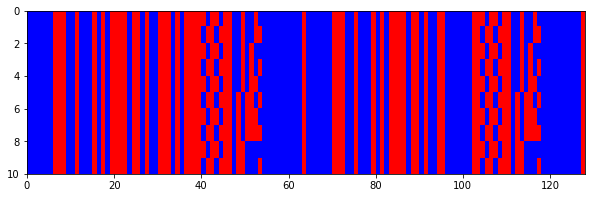

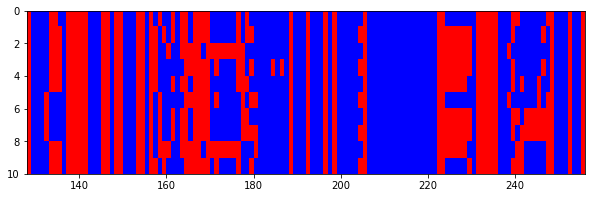

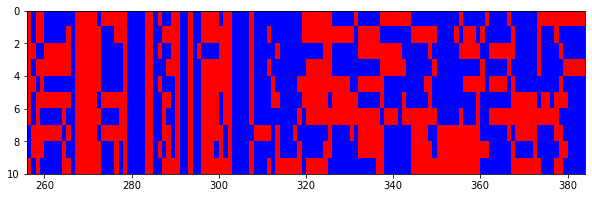

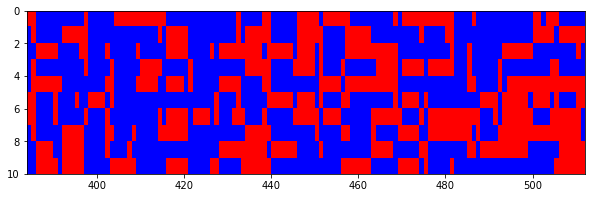

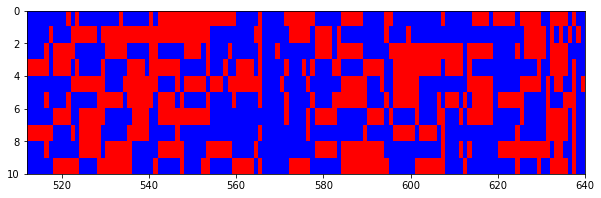

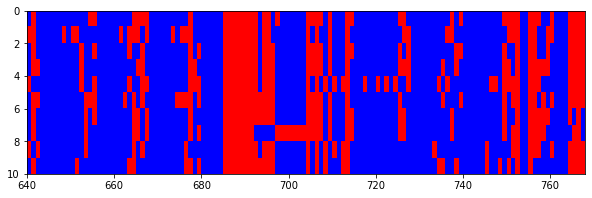

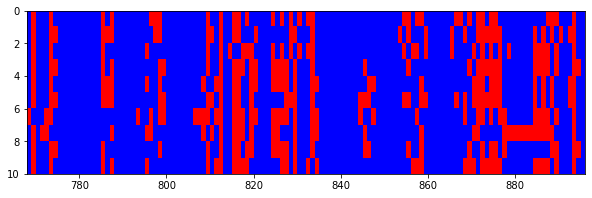

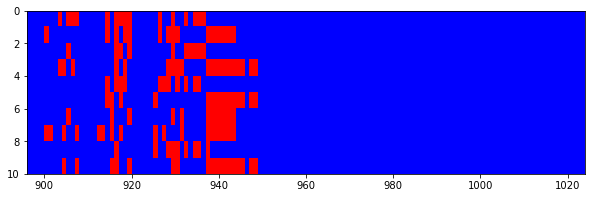

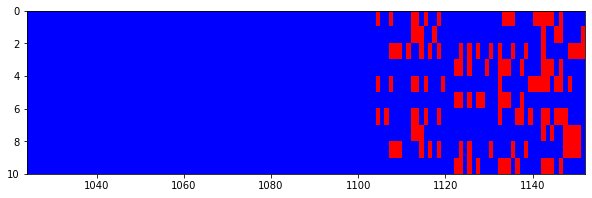

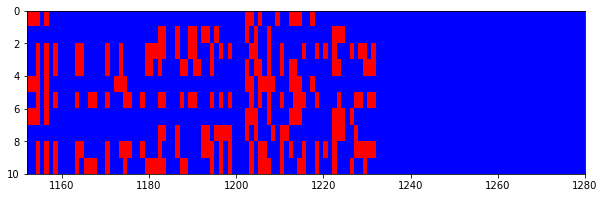

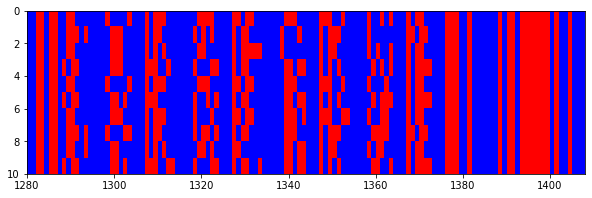

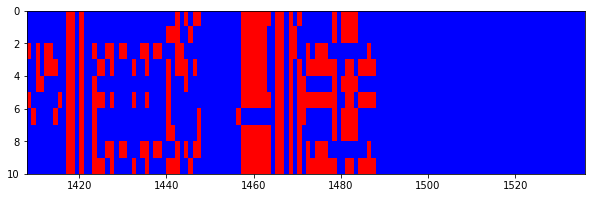

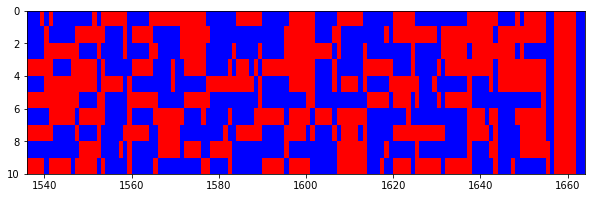

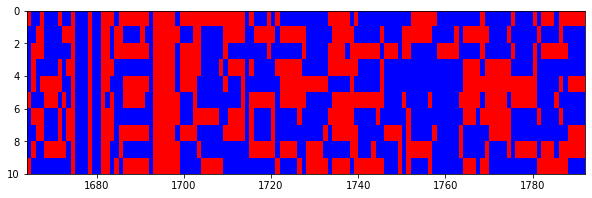

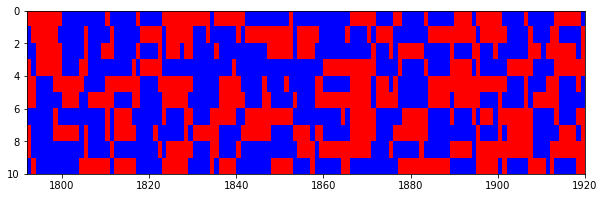

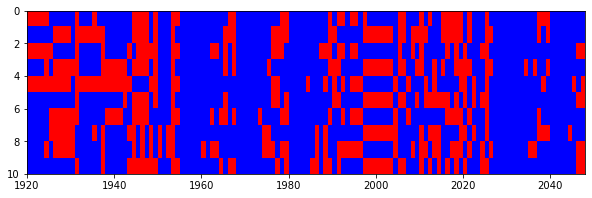

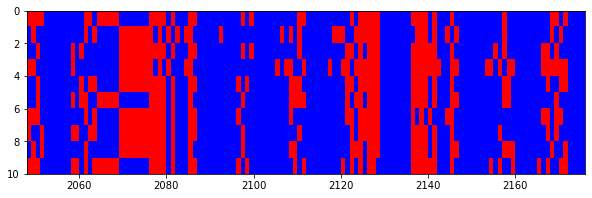

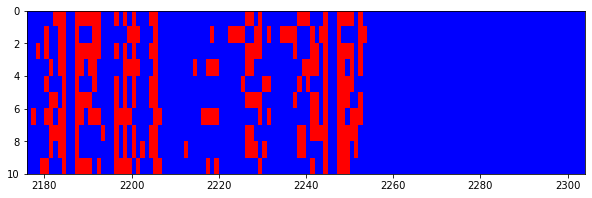

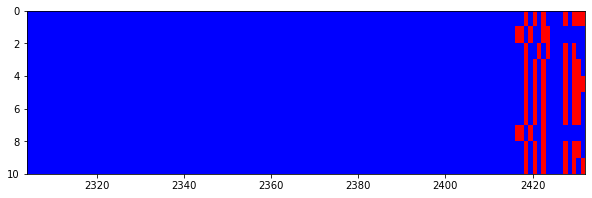

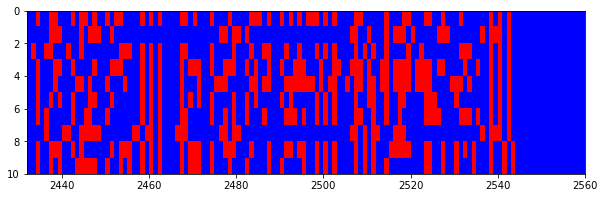

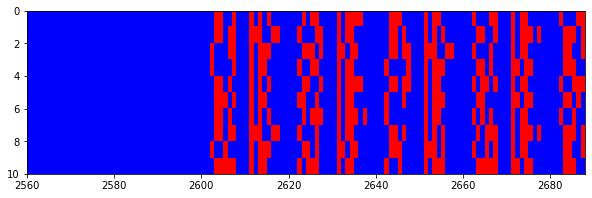

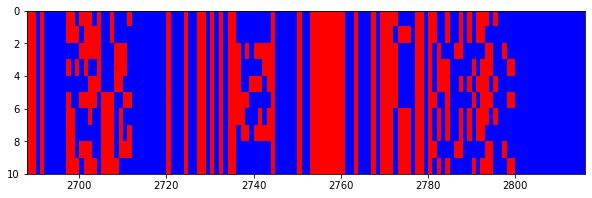

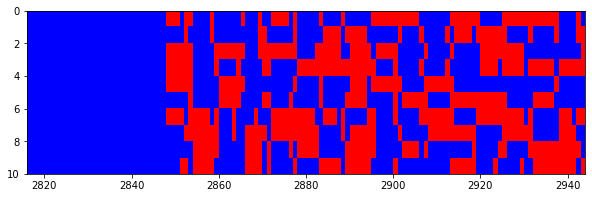

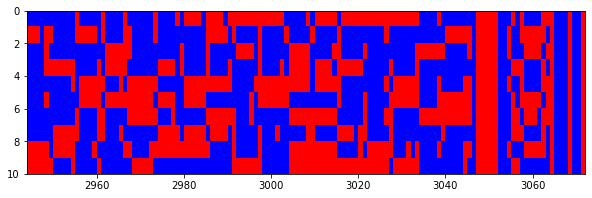

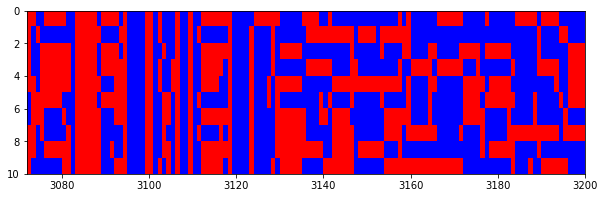

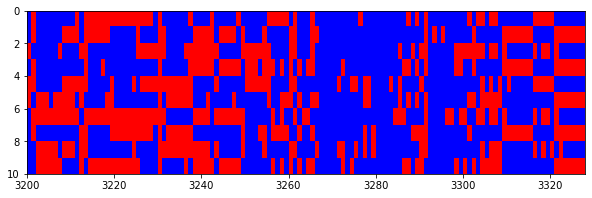

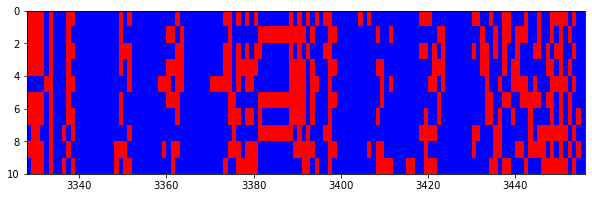

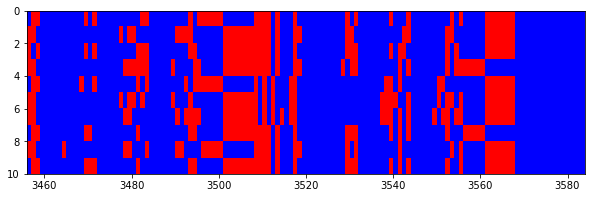

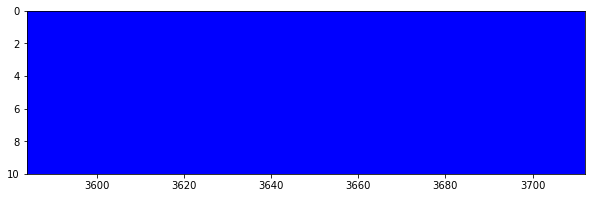

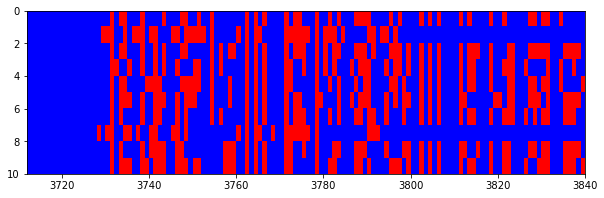

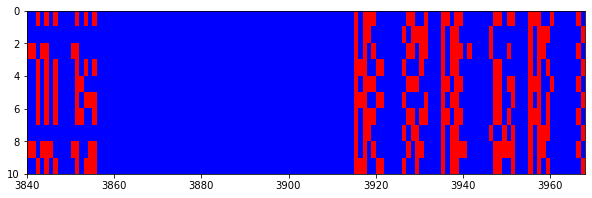

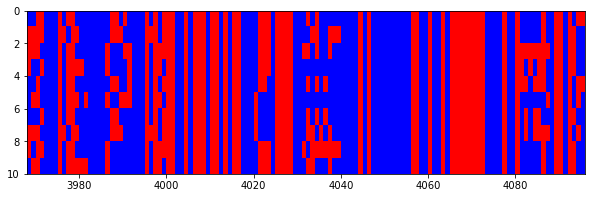

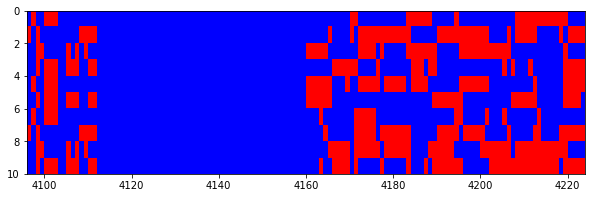

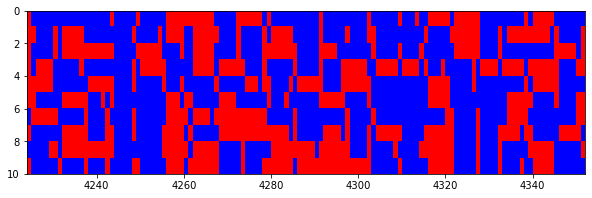

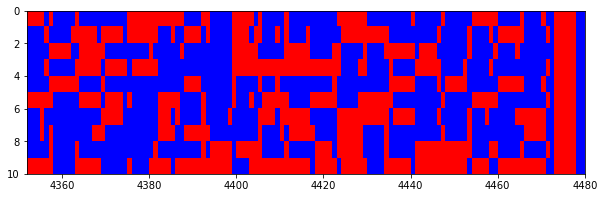

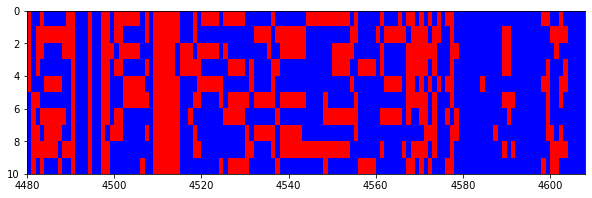

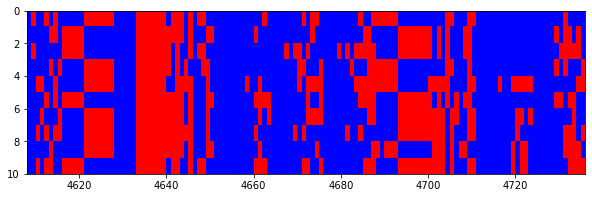

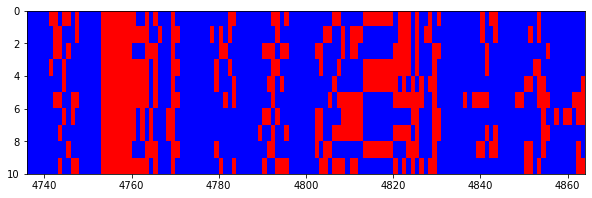

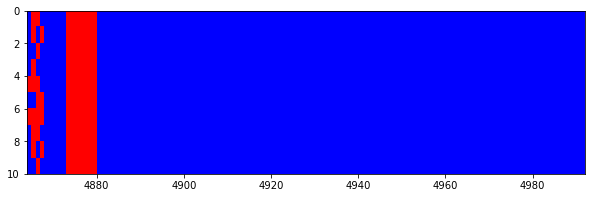

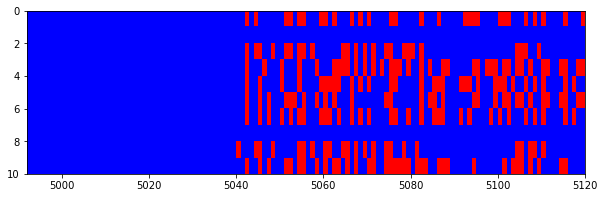

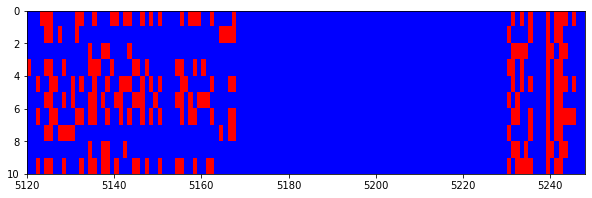

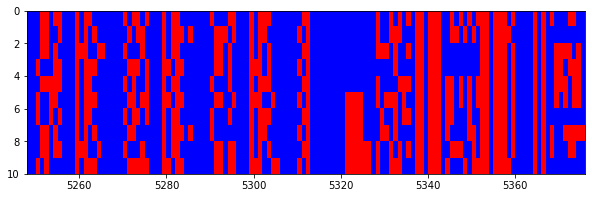

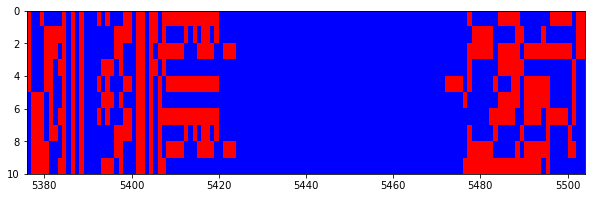

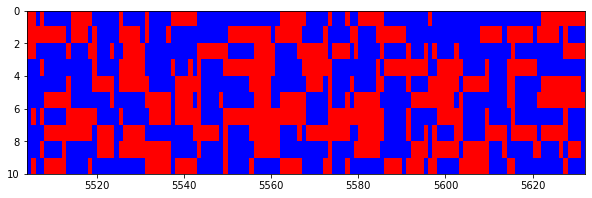

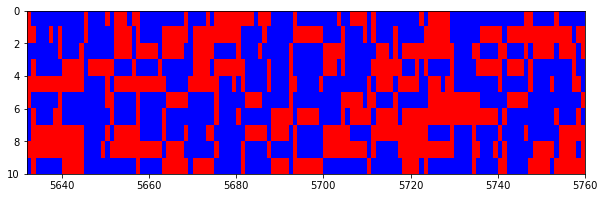

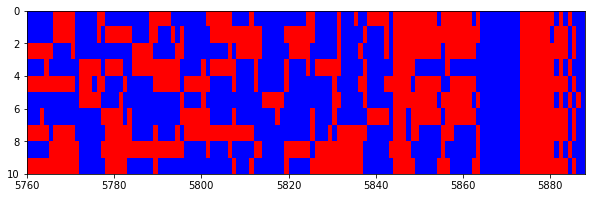

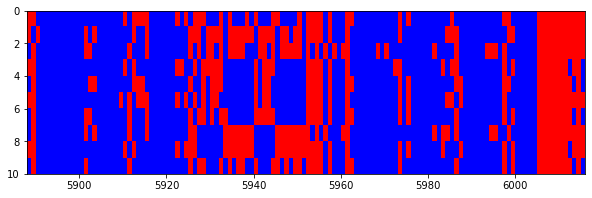

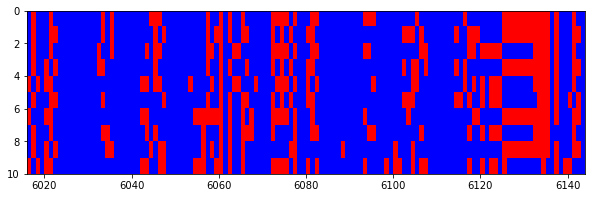

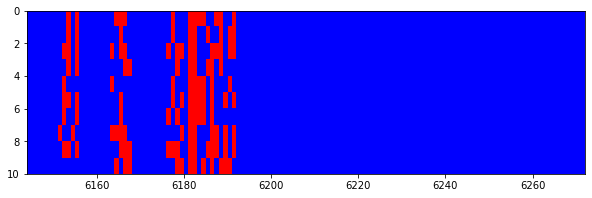

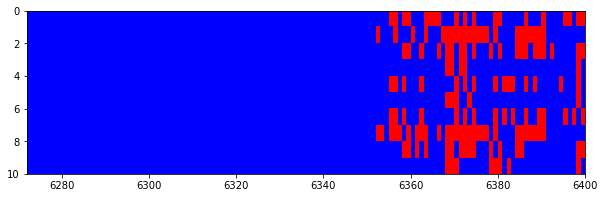

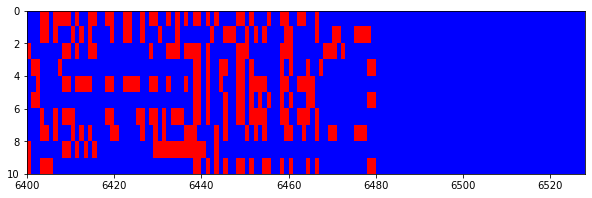

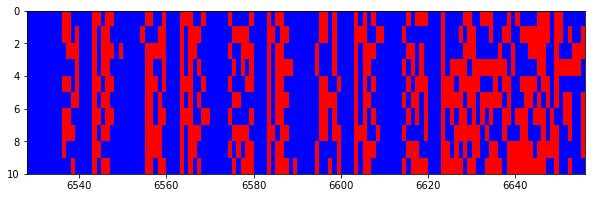

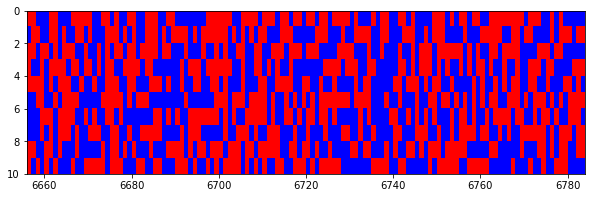

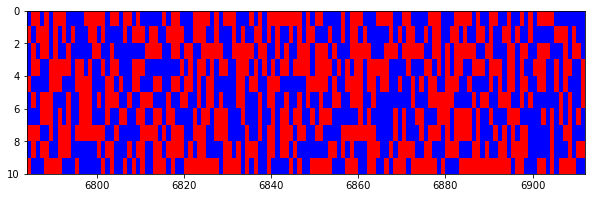

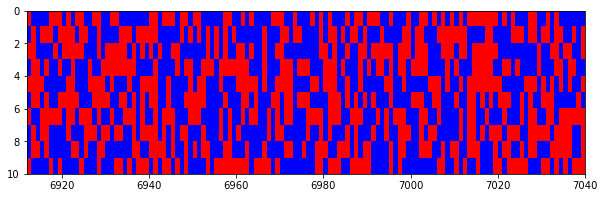

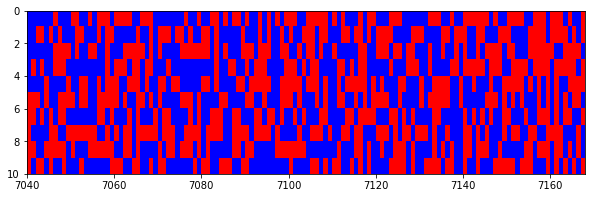

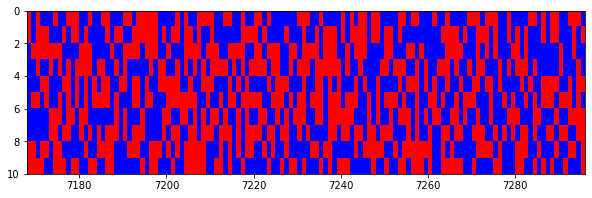

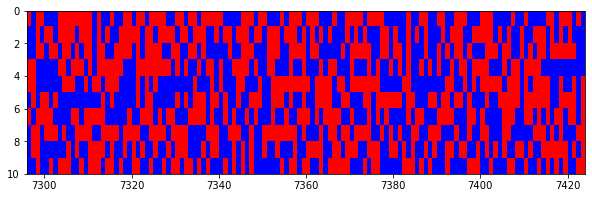

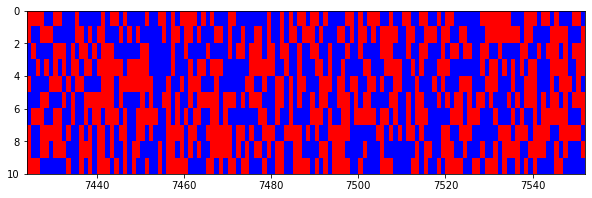

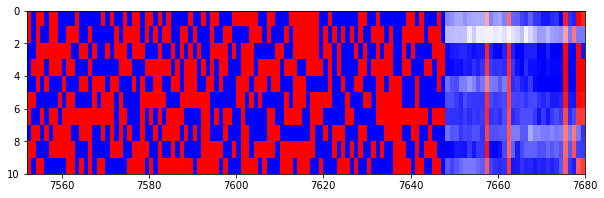

In [9]:
x = np.empty((decoded_frames.shape[0], 7680))
unpack = np.unpackbits(decoded_frames, axis=1)
x[:, :unpack.shape[1]] = 2*unpack.astype('float')-1
# Copy bits outside of RS codeword. These might have
# errors, so we copy them as soft bits
x[:, unpack.shape[1]:] = soft_frames[valid_frames, -32:]
n = 128
for j in range(0, x.shape[1], n):
    plt.figure(figsize=(10, 3))
    plt.imshow(x[:, j:j+n], aspect='auto', interpolation='none',
               extent=(j, j+n, x.shape[0], 0),
               vmin=-1, vmax=1, cmap='bwr')